In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rseed = 20090425

## Import and clean data

In [2]:
data_file = 'data/Bleeding_Dataonly_For Chris_04152016.xlsx'

raw_data = (pd.read_excel(data_file, sheetname='Bleeding_Outcomes_AllKQs',
                         na_values=['null', 'ND'])
            .drop(['Comments', 'Other stats \nName','Other Stats','Results','Comments 2',
                   'Presentation \nlocation','Last Assesment tmpt for the study','Followup duration category'], 
                  axis=1)
            .rename(columns={'Outcome timepoint (when was this outcome measured, e.g., in PACU, 12 months post─op, immediately post─op──would need a row for each outcome at each timepoint of interest)': 'outcome_time',
                             'OUTC_Main_\nCATG':'outcome_cat',
                            "Outc_SUB_\nCATG":'outcome_subcat',
                            'OUTCOME SAMPLE SIZE': 'N',
                             'Outcome\ncount': 'outcome_obs',
                            'Outcome  \n%': 'outcome_pct',
                            "Outcome\n Mean": 'outcome_mean',
                            "Outcome \nSD": 'outcome_sd',
                             'Outcome \n SE': 'outcome_se',
                             'Outcome\n _Q1': 'outcome_q1', 
                             'Outcome \n_Q3': 'outcome_q3',
                            "Outcome \n Median": 'outcome_med',
                            "Outcome \n 95% L": 'outcome_lo_95',
                            "Outcome \n 95% H": 'outcome_hi_95',
                            "Outcome\n  Min": 'outcome_min', 
                             'Outcome \n Max': 'outcome_max'}))

raw_data.head()

,Citation,REFID,Child Paper,Number of Arms,Rx Grouping,Group_Desc,Intervention_category,Dose,Route,Rx_Durn,...,outcome_mean,outcome_sd,outcome_se,outcome_med,outcome_q1,outcome_q3,outcome_min,outcome_max,outcome_lo_95,outcome_hi_95
0,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.0,8.0
1,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,6.0
3,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"H. S. Abdel-Ghaffar, H. G. Abdel-Azeem and M. ...",253,NaN,2,G1a:,Lornoxicam in one tonsil,perioperative NSAID,8 mg,Instillation/infiltration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
raw_data['Intervention_category'] = raw_data.Intervention_category.str.lower().str.strip()
clean_data = raw_data.replace({'Intervention_category':{'saline':'control',
                        'control (no rx)':'control',
                        'control (no dexamethasone)':'control',
                        'no antibiotics':'control',
                        'no steroid':'control',
                        'placebo':'control'}})

Counts of bleeding outcomes by major category

In [4]:
clean_data.New_Bleeding_specify.value_counts()

Reoperation-bleeding            162
Revisit/Readmission-bleeding    150
Undefined bleeding              121
Secondary bleeding              113
Primary bleeding                110
Name: New_Bleeding_specify, dtype: int64

Here is the full list of intervention categories. For the purposes of this analysis, I will just use the ones with "total" or "partial" in the name, and take them to be surgical interventions.

In [5]:
clean_data.Intervention_category.value_counts()

total cold                                                127
total electrocautery                                      124
total coblation                                            69
control                                                    48
perioperative steroid                                      47
total harmonic scalpel                                     28
partial coblation                                          25
total molecular resonance                                  20
perioperative nsaid                                        17
partial microdebrider                                      15
partial laser                                              15
total laser                                                13
partial cold                                               13
total thermal welding                                      12
postoperative analgesic                                     9
total tonsillectomy - unspecified                           6
perioper

Here is the surgery filter:

In [6]:
surgery_data = clean_data[clean_data.Intervention_category.str.contains('total') 
                   | clean_data.Intervention_category.str.contains('partial')].dropna(subset=['outcome_obs']).copy()

List of interventions after filtering. Note that there were a lot of papers that did not report bleeding outcomes, so the numbers dropped significantly. 

In [7]:
surgery_data.Intervention_category.value_counts()

total cold                                             74
total electrocautery                                   71
total coblation                                        34
total harmonic scalpel                                 22
total molecular resonance                              13
partial coblation                                      13
partial laser                                          12
total thermal welding                                  10
partial cold                                            7
partial microdebrider                                   6
total laser                                             6
total tonsillectomy - unspecified                       5
total argon plasma                                      3
total adenotonsillectomy - unspecified + no surgery     3
total adenotonsillectomy - unspecified                  1
total not specified                                     1
total microdebrider                                     1
total tonsille

Indicator for partial

In [8]:
surgery_data['partial'] = surgery_data.Intervention_category.str.contains('partial')

Generate column for technique

In [9]:
surgery_data['technique'] = (surgery_data.Intervention_category
        .apply(lambda x: ' '.join(x.split(' ')[1:]))
        .replace({'tonsillectomy - coblation':'coblation'}))

surgery_data = surgery_data[~(surgery_data.technique.str.contains('specified')|
                             surgery_data.technique.str.contains('\+'))]

In [10]:
surgery_data.technique.value_counts()

cold                   81
electrocautery         72
coblation              48
harmonic scalpel       22
laser                  18
molecular resonance    13
thermal welding        10
microdebrider           7
argon plasma            3
plasmaknife             1
Name: technique, dtype: int64

I will drop microdebrider, argon plasma and plasma knife due to lack of information.

In [11]:
technique_includes = surgery_data.technique.value_counts().index[:-3].tolist()
surgery_data = surgery_data[surgery_data.technique.isin(technique_includes)]

In [12]:
technique_includes

['cold',
 'electrocautery',
 'coblation',
 'harmonic scalpel',
 'laser',
 'molecular resonance',
 'thermal welding']

Subsets of data according to bleeding outcome

In [13]:
readmission_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Revisit/Readmission-bleeding']
reoperation_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Reoperation-bleeding']
primary_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Primary bleeding']
secondary_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Secondary bleeding']

## Model Specification

In [14]:
from pymc3 import (NUTS, sample, Model, Deterministic, find_MAP,
                  Binomial, Normal, HalfCauchy, advi,
                  traceplot, summary, forestplot)
import theano.tensor as tt

def tinvlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

In [17]:
def specify_model(model, data):
    
    N, REFID, events, partial = data[['N', 'REFID', 'outcome_obs', 'partial']].values.T
    
    refid_list = list(set(REFID))
    study_id = data.REFID.apply(lambda i: refid_list.index(i)).values
    n_studies = len(refid_list)
    
    technique = data.technique.apply(lambda i: technique_includes.index(i)).values
    n_tech = len(technique_includes)
    
    assert not np.isnan(N.astype(int)).any()
    assert not np.isnan(events.astype(int)).any()
    
    with model:
        
        # Mean for surgery interventions
        θ = Normal('θ', 0, sd=5, shape=n_tech, testval=np.ones(n_tech)*-1)
        # Effect of partial intervention
        β = Normal('β', 0, sd=5, testval=0)

        # Study random effect
        σ = HalfCauchy('σ', 5, testval=1)
        ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies, testval=np.zeros(n_studies))

        # Transform to probability scale
        π = tinvlogit(θ[technique] + β*partial.astype(int) + ϵ[study_id])

        # Mean probabilities
        π_total = Deterministic('π_total', tinvlogit(θ))
        π_partial = Deterministic('π_partial', tinvlogit(θ + β))

        # Data likelihood
        obs = Binomial('obs', N.astype(int), π, observed=events.astype(int))

    return model

In [18]:
reoperation_model = specify_model(Model(), reoperation_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


Model run using Hamiltonian Monte Carlo

In [19]:
with reoperation_model:
    reoperation_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 122.3 sec

In [32]:
readmission_model = specify_model(Model(), readmission_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


In [33]:
with readmission_model:
    readmission_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 131.3 sec

In [34]:
primary_model = specify_model(Model(), primary_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


In [35]:
with primary_model:
    primary_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 189.9 sec

In [36]:
secondary_model = specify_model(Model(), secondary_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


In [37]:
with secondary_model:
    secondary_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2001 of 2000 complete in 114.4 sec

## Reoperation Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

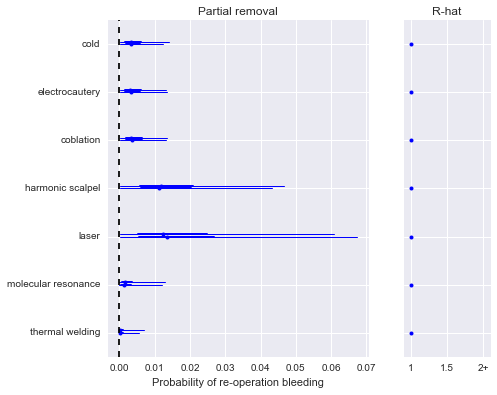

In [37]:
forestplot(reoperation_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of re-operation bleeding');

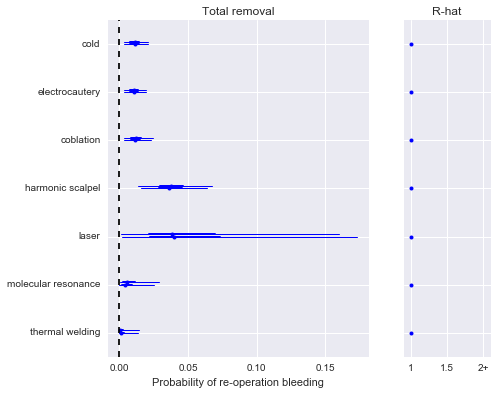

In [38]:
forestplot(reoperation_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of re-operation bleeding');

In [39]:
summary(reoperation_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.012            0.005            0.000            [0.003, 0.021]
  0.011            0.004            0.000            [0.003, 0.019]
  0.012            0.006            0.000            [0.003, 0.024]
  0.039            0.014            0.001            [0.015, 0.066]
  0.057            0.053            0.002            [0.002, 0.171]
  0.008            0.010            0.000            [0.000, 0.027]
  0.003            0.007            0.000            [0.000, 0.014]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.004          0.008          0.011          0.014          0.023
  0.004          0.008          0.010          0.013          0.021
  0.004          0.008          0.011          0.015          0.027
  0.017 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Readmission Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

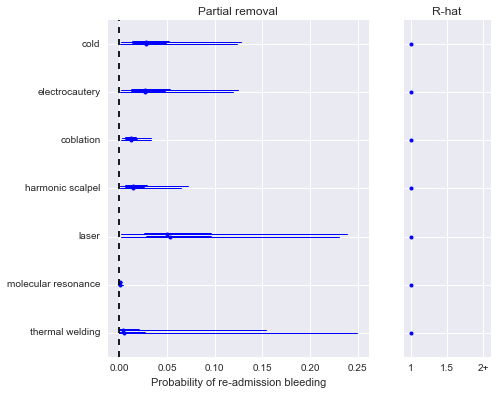

In [40]:
forestplot(readmission_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of re-admission bleeding');

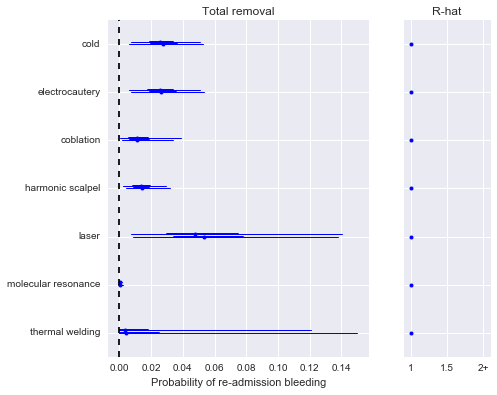

In [41]:
forestplot(readmission_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of re-admission bleeding');

In [42]:
summary(readmission_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.028            0.012            0.001            [0.008, 0.053]
  0.027            0.012            0.001            [0.006, 0.052]
  0.014            0.012            0.000            [0.001, 0.036]
  0.015            0.008            0.000            [0.003, 0.030]
  0.060            0.042            0.001            [0.008, 0.140]
  0.000            0.001            0.000            [0.000, 0.002]
  0.027            0.067            0.002            [0.000, 0.141]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.010          0.019          0.027          0.035          0.058
  0.009          0.018          0.026          0.035          0.058
  0.002          0.006          0.011          0.018          0.047
  0.004 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Primary Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

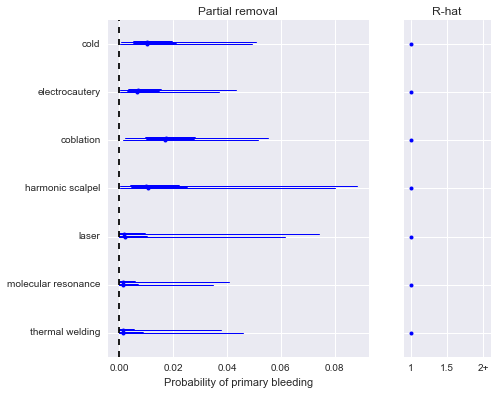

In [43]:
forestplot(primary_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of primary bleeding');

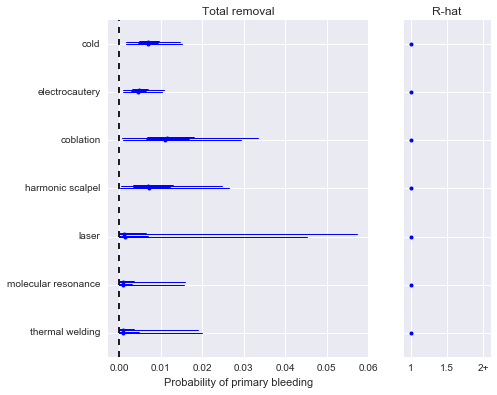

In [44]:
forestplot(primary_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of primary bleeding');

In [45]:
summary(primary_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.007            0.004            0.000            [0.002, 0.015]
  0.005            0.003            0.000            [0.001, 0.011]
  0.013            0.009            0.000            [0.001, 0.031]
  0.009            0.009            0.000            [0.000, 0.026]
  0.011            0.036            0.001            [0.000, 0.053]
  0.004            0.011            0.000            [0.000, 0.016]
  0.005            0.018            0.000            [0.000, 0.020]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.002          0.005          0.007          0.009          0.017
  0.001          0.003          0.005          0.007          0.012
  0.002          0.007          0.011          0.017          0.036
  0.001 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Secondary Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

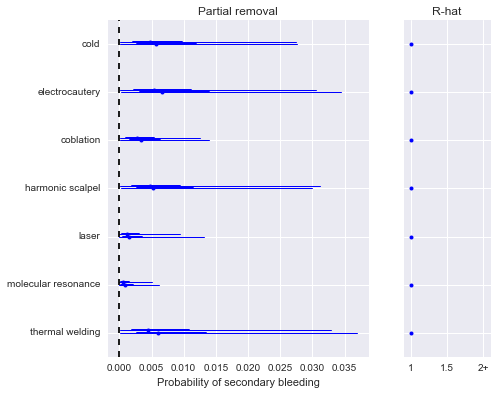

In [46]:
forestplot(secondary_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of secondary bleeding');

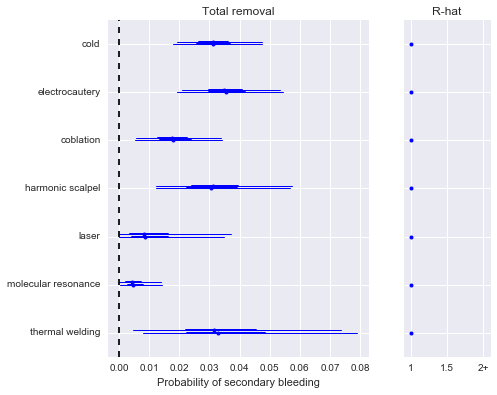

In [47]:
forestplot(secondary_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of secondary bleeding');

In [48]:
summary(secondary_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.032            0.008            0.000            [0.019, 0.047]
  0.036            0.009            0.000            [0.020, 0.054]
  0.019            0.008            0.000            [0.006, 0.034]
  0.032            0.012            0.000            [0.012, 0.057]
  0.012            0.012            0.000            [0.000, 0.035]
  0.006            0.004            0.000            [0.000, 0.014]
  0.037            0.021            0.001            [0.008, 0.079]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.019          0.026          0.031          0.036          0.049
  0.021          0.030          0.035          0.041          0.056
  0.007          0.013          0.018          0.023          0.038
  0.013 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Goodness of fit

Plots of Bayesian p-values. An excess of very large or very small values may suggest lack of fit.

In [53]:
from pymc3 import sample_ppc

ppc = [sample_ppc(trace, model=model, samples=500) for trace,model in ([reoperation_trace, reoperation_model],
                                                                      [readmission_trace, readmission_model],
                                                                      [primary_trace, primary_model],
                                                                      [secondary_trace, secondary_model])]

In [94]:
bayes_p = lambda sim, true: [(s > t).mean() for s,t in zip(sim, true)]

In [95]:
obs_sim = [p['obs'] for p in ppc]
p_values = [bayes_p(simdata, model.obs.tag.test_value) for simdata,model in zip(obs_sim, 
                                        [reoperation_model, readmission_model, primary_model, secondary_model])]  

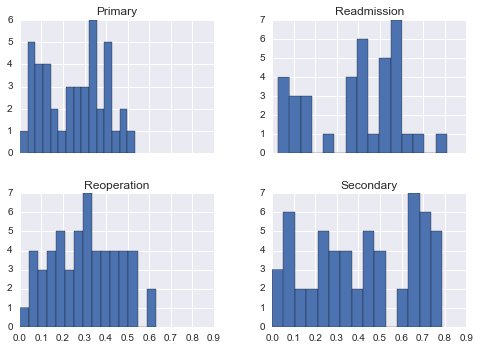

In [103]:
dfp = pd.DataFrame(p_values).T
dfp.columns = 'Reoperation', 'Readmission', 'Primary', 'Secondary'
dfp.hist(sharex=True, bins=15);